<a href="https://colab.research.google.com/github/Kakumanu-Harshitha/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Description:
A Style Transfer Model is designed to apply the artistic style of one image onto another, blending the content of a target image with the visual characteristics of a reference style image. The model typically uses Convolutional Neural Networks (CNNs) to separate and recombine the content and style features from the two images.

# Steps to Build:
1. import Libraries
2. Check for availabilty of device
3. Load Images
4. Caluculate Loss
5. Importing the Model
6. Optimization
7. Run Algorithm

# 1. import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import numpy as np
torch.autograd.set_detect_anomaly(True)

# 2. Check for availabilty of device

In [ ]:

device=torch.device ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 3.Load Images
Here the images are loaded with a size of (224,224) and convert all the images in to float.

In [ ]:
imsize = (224,224)

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])


def image_loader(image_path):
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_img = image_loader(r"/content/content image.jpg")
style_img = image_loader(r"/content/style image.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


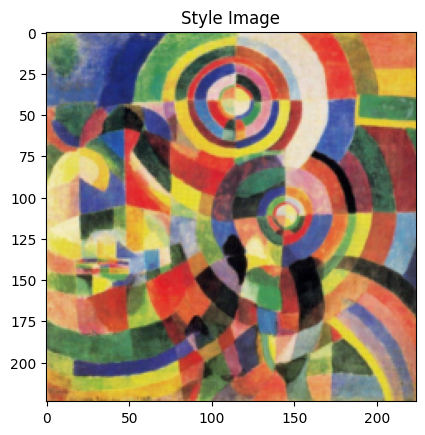

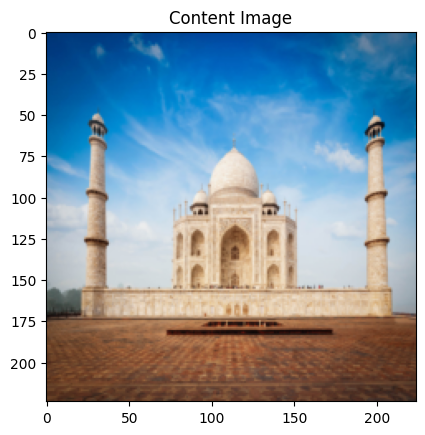

In [ ]:
unloader = transforms.ToPILImage()
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# 4. Caluculate Loss
**Content** **Loss**
The content loss is a function that represents a weighted version of the content distance for an individual layer. The function takes the feature maps
 of a layer
 in a network processing input
 and returns the weighted content distance
 between the image
 and the content image
. The feature maps of the content image(
) must be known by the function in order to calculate the content distance. We implement this function as a torch module with a constructor that takes
 as an input. The distance
 is the mean square error between the two sets of feature maps, and can be computed using nn.MSELoss.

We will add this content loss module directly after the convolution layer(s) that are being used to compute the content distance. This way each time the network is fed an input image the content losses will be computed at the desired layers and because of auto grad, all the gradients will be computed. Now, in order to make the content loss layer transparent we must define a forward method that computes the content loss and then returns the layer’s input. The computed loss is saved as a parameter of the module.

 **Style** **Loss** **& Gram Matrix**
The style loss module is implemented similarly to the content loss module. It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix
. A gram matrix is the result of multiplying a given matrix by its transposed matrix. In this application the given matrix is a reshaped version of the feature maps
 of a layer
.
 is reshaped to form
, a
\ x\
 matrix, where
 is the number of feature maps at layer
 and
 is the length of any vectorized feature map
. For example, the first line of
 corresponds to the first vectorized feature map
.

Finally, the gram matrix must be normalized by dividing each element by the total number of elements in the matrix. This normalization is to counteract the fact that
 matrices with a large
 dimension yield larger values in the Gram matrix. These larger values will cause the first layers (before pooling layers) to have a larger impact during the gradient descent. Style features tend to be in the deeper layers of the network so this normalization step is crucial.

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# 5. Importing the Model

Now we need to import a pre-trained neural network. We will use a 19 layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 93.4MB/s]


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        if name in content_layers:

            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:

            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


Next, we select the input image. You can use a copy of the content image or white noise.

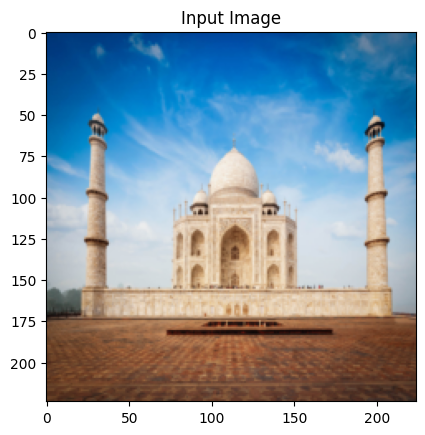

In [ ]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

# 6. Optimization
We will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimise the content/style losses. We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# 7. Run Algorithm
Run the algorithm for certain steps so that more steps may also leads to high style loss,so the image looks like no sharpeness and more smoothening.

In [ ]:


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=800,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


<ipython-input-10-2ba19fd3e4d6>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-2ba19fd3e4d6>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 350.271606 Content Loss: 30.583057

run [100]:
Style Loss : 92.313263 Content Loss: 32.425053

run [150]:
Style Loss : 39.652737 Content Loss: 33.090847

run [200]:
Style Loss : 21.959095 Content Loss: 32.757347

run [250]:
Style Loss : 13.756653 Content Loss: 31.960676

run [300]:
Style Loss : 9.581436 Content Loss: 31.036341

run [350]:
Style Loss : 7.056722 Content Loss: 30.124775

run [400]:
Style Loss : 5.553082 Content Loss: 29.383053

run [450]:
Style Loss : 4.560927 Content Loss: 28.727377

run [500]:
Style Loss : 3.910032 Content Loss: 28.203754

run [550]:
Style Loss : 3.477264 Content Loss: 27.752329

run [600]:
Style Loss : 3.204163 Content Loss: 27.387142

run [650]:
Style Loss : 3.008308 Content Loss: 27.093573

run [700]:
Style Loss : 2.845648 Content Loss: 26.844099

run [750]:
Style Loss : 2.722651 Content Loss: 26.624983

run [800]:
Style Loss : 2.619385 Content Loss: 26.419588



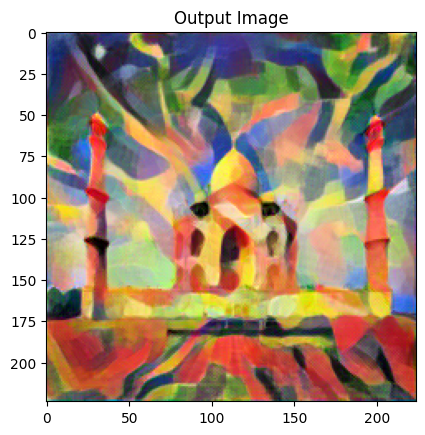

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

We got the style loss of 2.62 and content loss of 26.42 which is the best result. The output image looks like as same as content image but with style image features.